Kaye Ng and Vivian Uy's submission for Programming Assessment #4

INTRNLP S17

### Importing packages

In [1]:
import pandas as pd
import nltk
import numpy as np
import html
import re
import pickle
import csv

from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from symspellpy.symspellpy import SymSpell, Verbosity

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.pipeline import make_pipeline as make_pipeline_imb

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_colwidth', -1)

### Defining functions

In [2]:
def defaultPlotting():
    sns.set(rc={'figure.figsize': (12, 6)})
    sns.set_context("talk", rc={"font.size": 20, "axes.titlesize": 18, "axes.labelsize": 18})
    plt.rcParams['axes.spines.bottom'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.left'] = False
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.labelsize'] = 16
    plt.rcParams['axes.labelweight'] = 'bold'
    plt.rcParams['axes.titlesize'] = 16
    plt.rcParams['xtick.labelsize'] = 14
    plt.rcParams['ytick.labelsize'] = 14
    plt.rcParams['legend.fontsize'] = 14
    plt.rcParams['figure.titlesize'] = 24
    
defaultPlotting()

In [3]:
def plot_confusion_matrix(y_predict):
    classes = ['negative', 'neutral', 'positive']
    mat = confusion_matrix(y_test, y_predict)
    
    cm_sum = np.sum(mat, axis=1, keepdims=True)
    cm_perc = mat / cm_sum.astype(float) * 100
    
    annot = np.empty_like(mat).astype(str)
    nrows, ncols = mat.shape
    
    for i in range(nrows):
        for j in range(ncols):
            c = mat[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(mat, square=True, annot=annot, fmt='', vmax=800,
                xticklabels=classes, yticklabels=classes, annot_kws={"size": 14},
               cmap=sns.cm.rocket_r)
    
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.yticks(rotation=0)
    plt.title('Confusion matrix')
    
#     plt.savefig('confusion-matrix.png', bbox_inches="tight", dpi=300)
    plt.show()

In [4]:
def show_most_informative_features(vectorizer, clf, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t{:.4f}\t{: >15s}\t\t{:.4f}\t {: >15s}".format(coef_1, fn_1, coef_2, fn_2))

In [5]:
slang_dict = {}
contractions = {}

def load_dictionary(dictionary, filename):
    with open(filename, "r") as myCSVfile:
        dataFromFile = csv.reader(myCSVfile, delimiter="=")

        for row in dataFromFile:
            dictionary[row[0].lower()] = row[1].lower()

        myCSVfile.close()

load_dictionary(slang_dict, "data/slang.txt")
load_dictionary(contractions, "data/contractions.txt")

In [6]:
with open('pos_tag_corpus.pickle', 'rb') as handle:
    pos_set = pickle.load(handle)

In [7]:
max_edit_distance_dictionary = 2
prefix_length = 7
sym_spell = SymSpell(max_edit_distance_dictionary, prefix_length)

# term_index = 0  # column of the term in the dictionary text file
# count_index = 1  # column of the term frequency in the dictionary text file

if not sym_spell.load_dictionary("data/frequency_dictionary_en_82_765.txt", 0, 1):
    print("Dictionary file not found")

In [8]:
def get_correct_spelling(word):
    max_edit_distance_lookup = 2
    suggestion_verbosity = Verbosity.CLOSEST
    suggestions = sym_spell.lookup(word, suggestion_verbosity,
                                   max_edit_distance_lookup)

    if len(suggestions) > 0:
        return suggestions[0].term
    else:
        return word

In [9]:
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True)

def tokenize_text(tweet):
    return [token for token in tokenizer.tokenize(tweet) if len(token) > 2]

In [10]:
pattern = re.compile(r"(\b[-'.]\b)|[\W_]")

def remove_punct(doc):
    return pattern.sub(lambda m: (m.group(1) if m.group(1) else " "), doc)

In [11]:
def reduce_word(word):
    p = re.compile(r"(.)\1{2,}")
    return p.sub(r"\1\1", word)

In [12]:
class LemmatizationWithPOSTagger(object):
    def __init__(self):
        pass
    
    def get_wordnet_pos(self, treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            # default pos in lemmatization is noun
            return wordnet.NOUN

In [13]:
def preprocess(word):
    word = get_correct_spelling(word)
    
    if word in pos_set:
        tag = pos_set[word]
    else:
        tag = nltk.pos_tag([word])[0][1]
    
    #filter out non-verbs, non-adjectives and non-adverbs then lemmatize
    if tag.startswith(("V", "J", "R")):
        return WordNetLemmatizer().lemmatize(word.strip().replace(".", ""),
                                      pos=LemmatizationWithPOSTagger().get_wordnet_pos(
                                                        tag))
    
    return ""

In [14]:
class TokenizeTweet(object):
    def __call__(self, doc):
        cleaned = []
        tokenize = tokenize_text(doc)

        for token in tokenize:

            if not token.startswith(('#', 'http://')):
                token = reduce_word(token)
                token = remove_punct(token)

                if token in slang_dict.keys():
    #                     print('slang found:', slang_dict[token])

                    for word in slang_dict[token].split():
                        token = preprocess(word)
                        if token.strip() != "":
                            cleaned.append(token)

                elif token in contractions.keys():
    #                     print('contraction found:', contractions[token])

                    for word in contractions[token].split():
                        token = preprocess(word)
                        if token.strip() != "":
                            cleaned.append(token)

                else:
                    cleaned.append(preprocess(token))

        return [word.strip() for word in cleaned if word != '']

### Reading and inspecting the data

In [15]:
df = pd.read_csv('data/Virgin America and US Airways Tweets.csv', sep='\t')

df.head()

,airline_sentiment,airline,text
0,neutral,Virgin America,@VirginAmerica What @dhepburn said.
1,positive,Virgin America,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,Virgin America,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,Virgin America,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,Virgin America,@VirginAmerica and it's a really big bad thing about it


### Understanding the corpus

In [16]:
df.dtypes

airline_sentiment    object
airline              object
text                 object
dtype: object

In [17]:
df.shape

(3417, 3)

In [18]:
df.describe(include='all')

,airline_sentiment,airline,text
count,3417,3417,3417
unique,3,2,3409
top,negative,US Airways,@USAirways thanks
freq,2444,2913,3


In [19]:
df.isnull().sum()

airline_sentiment    0
airline              0
text                 0
dtype: int64

In [20]:
df.airline_sentiment.value_counts()

negative    2444
neutral     552 
positive    421 
Name: airline_sentiment, dtype: int64

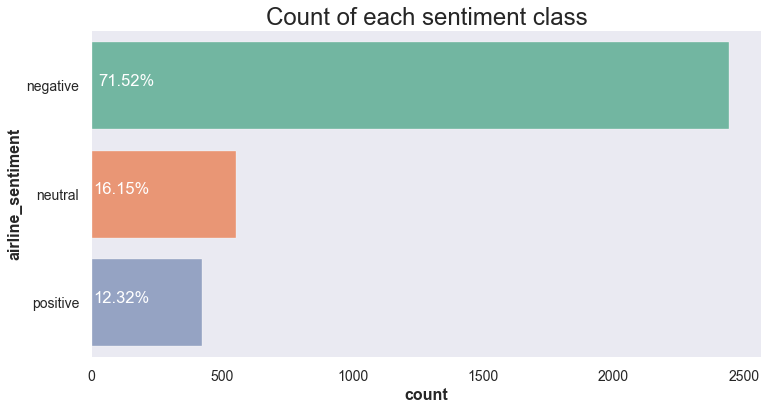

In [21]:
pct = ((df.airline_sentiment.value_counts() / df.airline_sentiment.count()) * 100)

ax = sns.countplot(y="airline_sentiment", data=df, palette="Set2", linewidth=0.3,
                   order = df.airline_sentiment.value_counts().index)

for i, p in enumerate(ax.patches):
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.annotate('{0:.2f}%'.format(pct[i]), (p.get_x() + 0.01 * width, p.get_y() + .45 * height), 
                color='white', ha='left', va='center', fontsize='small')

plt.title('Count of each sentiment class', fontsize=24)
plt.grid(False)

In [22]:
# get total words per class

def count_words(nArray):
    punct = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{}~'
    transtab = str.maketrans(dict.fromkeys(punct, ''))

    word_count = 0
    for sentence in nArray:
        tokens = nltk.word_tokenize(sentence.translate(transtab))
        
        # the translate portion just removed the punctuation
        word_count += len(tokens)

    return word_count

print("Total words in negative tweets:", count_words(df.loc[df.airline_sentiment == 'negative'].text.values))

print("Total words in neutral tweets:", count_words(df.loc[df.airline_sentiment == 'neutral'].text.values))

print("Total words in positive tweets:", count_words(df.loc[df.airline_sentiment == 'positive'].text.values))

Total words in negative tweets: 48095
Total words in neutral tweets: 8327
Total words in positive tweets: 5928


### Pre-processing the text

In [23]:
df.iloc[5].text

"@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA"

There are some values containing `\n`, so let's remove those.

In [24]:
df['text'] = df['text'].apply(lambda x: x.replace("\n", " "))

In [25]:
df.iloc[5].text

"@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing. it's really the only bad thing about flying VA"

We can see that `\n` was correctly replaced with a space.

In [26]:
df.iloc[3].text

'@VirginAmerica it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse'

There are some symbols that were encoded as HTML character entities, so we need to convert them back to symbols.

In [27]:
df['text'] = df['text'].apply(lambda x: html.unescape(x))

In [28]:
df.iloc[3].text

'@VirginAmerica it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces & they have little recourse'

We can see that the `&` character was converted back into symbol form.

**Problem**: how to convert symbols (incl. emoji) into words?

Example:

In [29]:
df.iloc[11].text

'@VirginAmerica I <3 pretty graphics. so much better than minimal iconography. :D'

<3 --> 'love' ?

**Problem**: typos

Example:

In [30]:
df.iloc[182].text

'@VirginAmerica Flight from BOS > LAS tomorrow was Cancelled Flightled. No notification; wait times are 1+ hour. Will you rebook on another airline?'

**Problem**: slang words

Example:

In [31]:
df.iloc[3414].text

'@USAirways reservations had me on hold for 2 hours only to hang up...smh 😕'

### Splitting into training and testing sets

In [32]:
X = df.text
y = df.airline_sentiment

X_train, X_test, y_train, y_test = train_test_split(
    X, # Features
    y, # Labels
    test_size = 0.3, # The defined test size; Training size is just 1 minus the test size
    random_state = 42 # So we can shuffle the elements, but with some consistency
)

print("=====\nTraining Data")
print("Document count: %s" % len(y_train))
labels, counts = np.unique(y_train, return_counts=True)
for label, count in zip(labels, counts):
    print("%s: %s (%.4f)" % (label, count, count/len(y_train)))
        
print("=====\nTesting Data")
print("Document count: %s" % len(y_test))
labels, counts = np.unique(y_test, return_counts=True)
for label, count in zip(labels, counts):
    print("%s: %s (%.4f)" % (label, count, count/len(y_test)))

=====
Training Data
Document count: 2391
negative: 1723 (0.7206)
neutral: 378 (0.1581)
positive: 290 (0.1213)
=====
Testing Data
Document count: 1026
negative: 721 (0.7027)
neutral: 174 (0.1696)
positive: 131 (0.1277)


### Extracting features from text

In [33]:
vectorizer = CountVectorizer(tokenizer=TokenizeTweet(), binary=True,
                             max_df=0.9, ngram_range=(1, 3), lowercase=False)

# vectorizer = TfidfVectorizer(tokenizer=TokenizeTweet(), binary=True,
#                              max_df=0.9, ngram_range=(1, 3), lowercase=False)

x = vectorizer.fit_transform(X_train)
count_vect_df = pd.DataFrame(x.todense(), columns=vectorizer.get_feature_names())

count_vect_df.head()

,1874get,1874get late,2hr15min,2hr15min have,2hr15min have estimate,3hr30min,3hr30min right,3hr30min right now,50minss,513mph,...,yet tonnes,yet tonnes explain,yield,yield be,yield be exact,young,young american,young american new,yummy,zip
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
count_vect_df.sum(axis=0)

1874get                   1 
1874get late              1 
2hr15min                  1 
2hr15min have             1 
2hr15min have estimate    1 
3hr30min                  1 
3hr30min right            1 
3hr30min right now        1 
50minss                   1 
513mph                    1 
513mph strong             1 
639p                      1 
639p deliver              1 
able                      15
able able                 1 
able able make            1 
able buy                  1 
able buy speak            1 
able call                 1 
able call tell            1 
able complete             1 
able complete waste       1 
able do                   1 
able do not               1 
able earlier              1 
able entire               1 
able entire hold          1 
able get                  1 
able get reschedule       1 
able locate               1 
                         .. 
yet hate much             1 
yet have                  2 
yet have good             1 
yet have tight

### Training the models

In [35]:
pipe = make_pipeline_imb(
    vectorizer,
    RandomUnderSampler(),
#     NearMiss(),
    MultinomialNB()
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred), '\n')
print(classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=y_pred))

Accuracy:  0.7076023391812866 

              precision    recall  f1-score   support

    negative   0.827109  0.829404  0.828255       721
     neutral   0.393701  0.287356  0.332226       174
    positive   0.443182  0.595420  0.508143       131

   micro avg   0.707602  0.707602  0.707602      1026
   macro avg   0.554664  0.570727  0.556208      1026
weighted avg   0.704587  0.707602  0.703261      1026



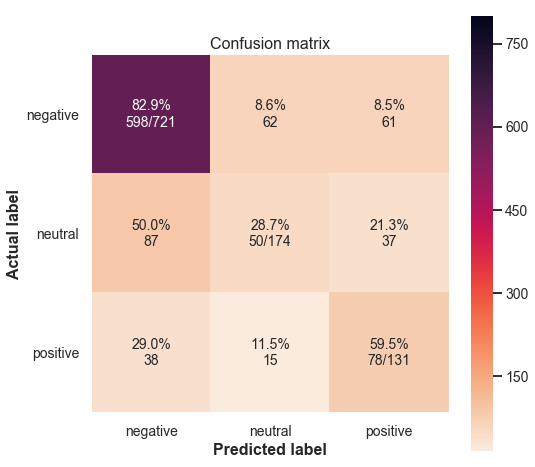

In [36]:
plot_confusion_matrix(pipe.predict(X_test))

## Other configurations

### Near miss undersampling

### <div style="background-color: #4D776B; color: #fcfcfc; padding: 1.2em;"><span style="float: right;">With preprocessing</span></div>

CountVectorizer, 90% threshold, binary

Accuracy:  0.38693957115009747 

              precision    recall  f1-score   support

    negative   0.820789  0.317614  0.458000       721
     neutral   0.241758  0.379310  0.295302       174
    positive   0.215190  0.778626  0.337190       131

   micro avg   0.386940  0.386940  0.386940      1026
   macro avg   0.425912  0.491850  0.363497      1026
weighted avg   0.645267  0.386940  0.414983      1026



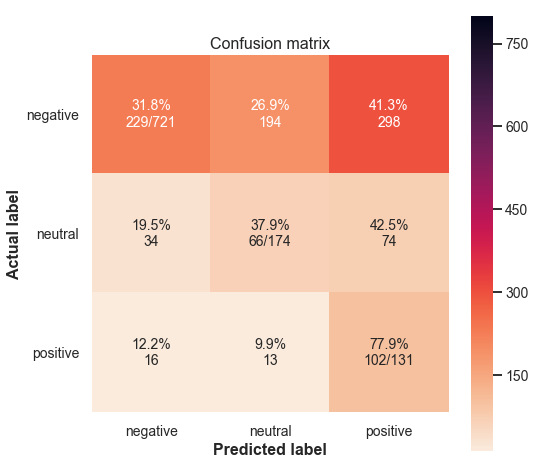

In [48]:
vectorizer = CountVectorizer(tokenizer=TokenizeTweet(), binary=True,
                             max_df=0.9, ngram_range=(1, 3), lowercase=False)

pipe = make_pipeline_imb(
    vectorizer,
    NearMiss(),
    MultinomialNB()
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred), '\n')
print(classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=y_pred))

plot_confusion_matrix(pipe.predict(X_test))

In [49]:
show_most_informative_features(pipe.named_steps['countvectorizer'], pipe.named_steps['multinomialnb'])

	-9.7082	        1874get		-5.6307	              be
	-9.7082	   1874get late		-6.5301	             get
	-9.7082	       2hr15min		-6.5727	            have
	-9.7082	  2hr15min have		-6.8750	             not
	-9.7082	2hr15min have estimate		-6.9356	            wait
	-9.7082	       3hr30min		-6.9356	           still
	-9.7082	 3hr30min right		-7.0002	             bad
	-9.7082	3hr30min right now		-7.0691	              do
	-9.7082	        50minss		-7.1433	             now
	-9.7082	         513mph		-7.5110	          please


CountVectorizer, 90% threshold

Accuracy:  0.3664717348927875 

              precision    recall  f1-score   support

    negative   0.812500  0.288488  0.425793       721
     neutral   0.252874  0.379310  0.303448       174
    positive   0.200393  0.778626  0.318750       131

   micro avg   0.366472  0.366472  0.366472      1026
   macro avg   0.421922  0.482142  0.349331      1026
weighted avg   0.639439  0.366472  0.391377      1026



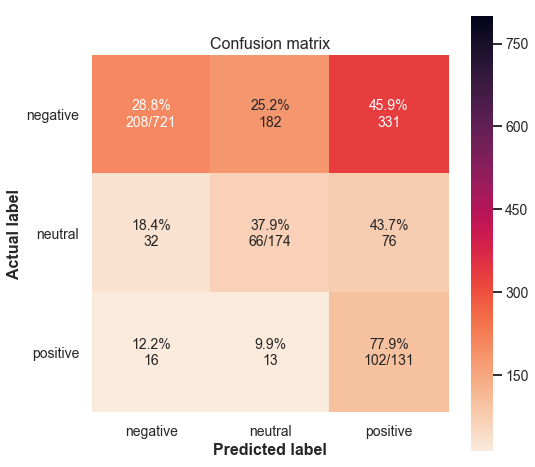

In [39]:
vectorizer = CountVectorizer(tokenizer=TokenizeTweet(), binary=False,
                             max_df=0.9, ngram_range=(1, 3), lowercase=False)

pipe = make_pipeline_imb(
    vectorizer,
    NearMiss(),
    MultinomialNB()
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred), '\n')
print(classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=y_pred))

plot_confusion_matrix(pipe.predict(X_test))

In [40]:
show_most_informative_features(pipe.named_steps['countvectorizer'], pipe.named_steps['multinomialnb'])

	-9.7087	        1874get		-5.5979	              be
	-9.7087	   1874get late		-6.5307	             get
	-9.7087	       2hr15min		-6.6177	            have
	-9.7087	  2hr15min have		-6.8755	            wait
	-9.7087	2hr15min have estimate		-6.9362	           still
	-9.7087	       3hr30min		-7.0007	             not
	-9.7087	 3hr30min right		-7.0697	              do
	-9.7087	3hr30min right now		-7.1438	             now
	-9.7087	        50minss		-7.1438	             bad
	-9.7087	         513mph		-7.5115	          please


TfidfVectorizer, 90% threshold, binary

Accuracy:  0.6432748538011696 

              precision    recall  f1-score   support

    negative   0.845361  0.682386  0.755180       721
     neutral   0.321429  0.465517  0.380282       174
    positive   0.453125  0.664122  0.538700       131

   micro avg   0.643275  0.643275  0.643275      1026
   macro avg   0.539971  0.604008  0.558054      1026
weighted avg   0.706426  0.643275  0.663961      1026



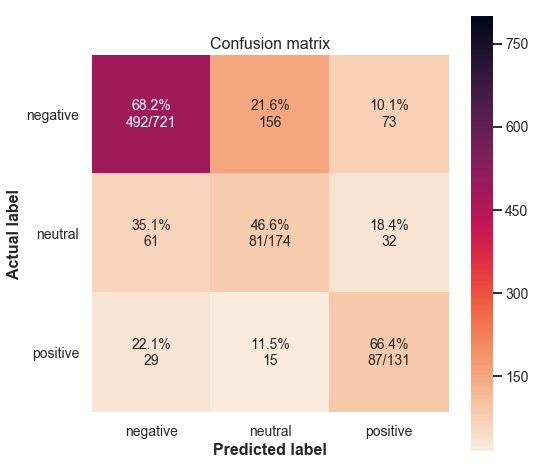

In [41]:
vectorizer = TfidfVectorizer(tokenizer=TokenizeTweet(), binary=True,
                             max_df=0.9, ngram_range=(1, 3), lowercase=False)

pipe = make_pipeline_imb(
    vectorizer,
    NearMiss(),
    MultinomialNB()
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred), '\n')
print(classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=y_pred))

plot_confusion_matrix(pipe.predict(X_test))

In [42]:
show_most_informative_features(pipe.named_steps['tfidfvectorizer'], pipe.named_steps['multinomialnb'])

	-9.7092	        1874get		-7.0503	              be
	-9.7092	   1874get late		-7.3179	             get
	-9.7092	       2hr15min		-7.6916	            have
	-9.7092	  2hr15min have		-7.7414	             not
	-9.7092	2hr15min have estimate		-8.0108	              do
	-9.7092	       3hr30min		-8.1843	             now
	-9.7092	 3hr30min right		-8.2466	           never
	-9.7092	3hr30min right now		-8.2569	            wait
	-9.7092	         513mph		-8.2999	         have be
	-9.7092	  513mph strong		-8.3307	          cancel


TfidfVectorizer, 90% threshold

Accuracy:  0.6413255360623782 

              precision    recall  f1-score   support

    negative   0.836425  0.687933  0.754947       721
     neutral   0.312757  0.436782  0.364508       174
    positive   0.452632  0.656489  0.535826       131

   micro avg   0.641326  0.641326  0.641326      1026
   macro avg   0.533938  0.593735  0.551760      1026
weighted avg   0.698613  0.641326  0.660755      1026



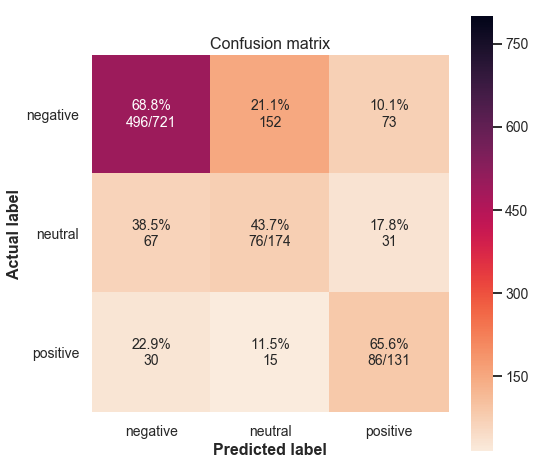

In [43]:
vectorizer = TfidfVectorizer(tokenizer=TokenizeTweet(), binary=False,
                             max_df=0.9, ngram_range=(1, 3), lowercase=False)

pipe = make_pipeline_imb(
    vectorizer,
    NearMiss(),
    MultinomialNB()
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred), '\n')
print(classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=y_pred))

plot_confusion_matrix(pipe.predict(X_test))

### <div style="background-color: #4D776B; color: #fcfcfc; padding: 1.2em;"><span style="float: right;">No preprocessing</span></div>

CountVectorizer, 90% threshold, binary

Accuracy:  0.5526315789473685 

              precision    recall  f1-score   support

    negative   0.945799  0.484050  0.640367       721
     neutral   0.369565  0.586207  0.453333       174
    positive   0.304462  0.885496  0.453125       131

   micro avg   0.552632  0.552632  0.552632      1026
   macro avg   0.539942  0.651918  0.515608      1026
weighted avg   0.766189  0.552632  0.584741      1026



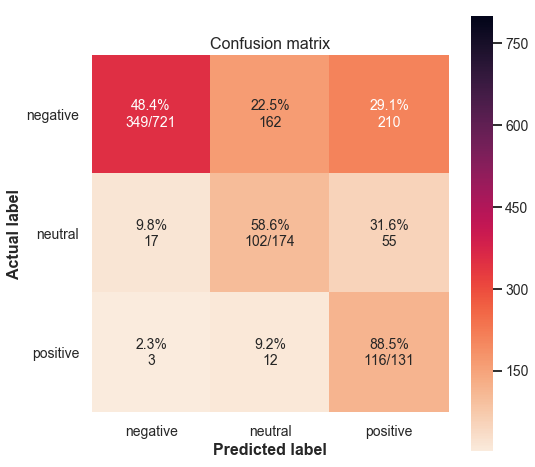

In [70]:
pipe = make_pipeline_imb(
    CountVectorizer(binary=True),
    NearMiss(),
    MultinomialNB()
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred), '\n')
print(classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=y_pred))

plot_confusion_matrix(pipe.predict(X_test))

In [71]:
show_most_informative_features(pipe.named_steps['countvectorizer'], pipe.named_steps['multinomialnb'])

	-8.9313	             00		-3.3109	       usairways
	-8.9313	         000419		-4.7118	             you
	-8.9313	         000lbs		-4.9800	             the
	-8.9313	           00am		-4.9995	              to
	-8.9313	           00pm		-5.0193	              on
	-8.9313	           0185		-5.1471	             and
	-8.9313	           01pm		-5.1701	              is
	-8.9313	             05		-5.1701	             for
	-8.9313	           05am		-5.3759	          flight
	-8.9313	           05pm		-5.4049	              my


CountVectorizer, 90% threshold

Accuracy:  0.52046783625731 

              precision    recall  f1-score   support

    negative   0.941176  0.443828  0.603205       721
     neutral   0.363971  0.568966  0.443946       174
    positive   0.277778  0.877863  0.422018       131

   micro avg   0.520468  0.520468  0.520468      1026
   macro avg   0.527642  0.630219  0.489723      1026
weighted avg   0.758585  0.520468  0.553062      1026



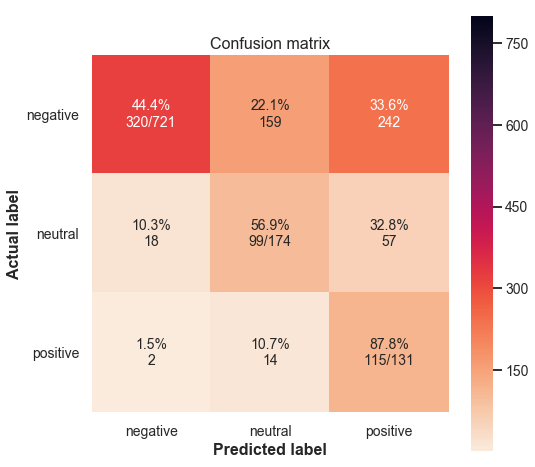

In [72]:
pipe = make_pipeline_imb(
    CountVectorizer(),
    NearMiss(),
    MultinomialNB()
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred), '\n')
print(classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=y_pred))

plot_confusion_matrix(pipe.predict(X_test))

In [73]:
show_most_informative_features(pipe.named_steps['countvectorizer'], pipe.named_steps['multinomialnb'])

	-8.9434	             00		-3.2979	       usairways
	-8.9434	         000419		-4.7537	             you
	-8.9434	         000lbs		-4.8829	              to
	-8.9434	           00am		-4.9180	             the
	-8.9434	            00p		-5.0314	              on
	-8.9434	           00pm		-5.1592	             for
	-8.9434	           0185		-5.2057	             and
	-8.9434	           01pm		-5.2298	              is
	-8.9434	             05		-5.3325	            hold
	-8.9434	           05am		-5.3599	            your


TfidfVectorizer, 90% threshold, binary

Accuracy:  0.7504873294346979 

              precision    recall  f1-score   support

    negative   0.870015  0.816921  0.842632       721
     neutral   0.441748  0.522989  0.478947       174
    positive   0.629371  0.687023  0.656934       131

   micro avg   0.750487  0.750487  0.750487      1026
   macro avg   0.647044  0.675644  0.659505      1026
weighted avg   0.766659  0.750487  0.757245      1026



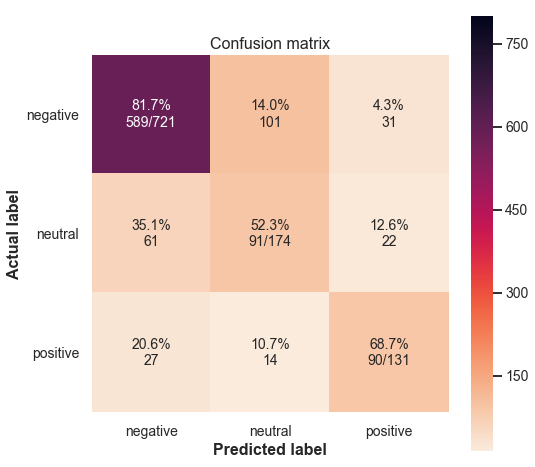

In [74]:
pipe = make_pipeline_imb(
    TfidfVectorizer(binary=True),
    NearMiss(),
    MultinomialNB()
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred), '\n')
print(classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=y_pred))

plot_confusion_matrix(pipe.predict(X_test))

In [75]:
show_most_informative_features(pipe.named_steps['tfidfvectorizer'], pipe.named_steps['multinomialnb'])

	-8.6843	             00		-5.7184	       usairways
	-8.6843	            000		-5.9060	             you
	-8.6843	         000lbs		-6.1080	             the
	-8.6843	           00am		-6.2130	              my
	-8.6843	           00pm		-6.2512	             for
	-8.6843	           0185		-6.2637	              on
	-8.6843	           01pm		-6.2686	              to
	-8.6843	           0400		-6.2868	             and
	-8.6843	     04sdytt7zd		-6.4091	          flight
	-8.6843	             05		-6.4528	              me


TfidfVectorizer, 90% threshold

Accuracy:  0.7563352826510721 

              precision    recall  f1-score   support

    negative   0.871157  0.825243  0.847578       721
     neutral   0.432692  0.517241  0.471204       174
    positive   0.674074  0.694656  0.684211       131

   micro avg   0.756335  0.756335  0.756335      1026
   macro avg   0.659308  0.679047  0.667664      1026
weighted avg   0.771634  0.756335  0.762890      1026



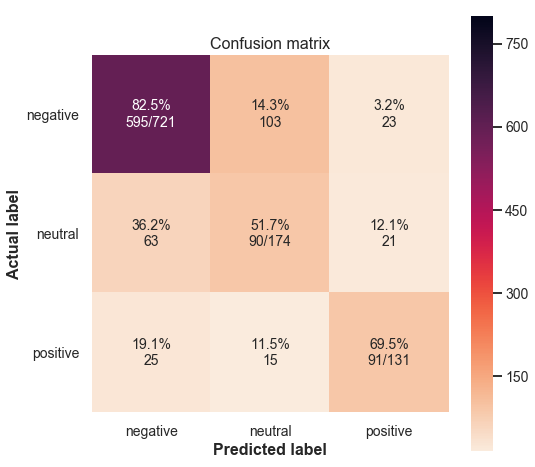

In [76]:
pipe = make_pipeline_imb(
    TfidfVectorizer(),
    NearMiss(),
    MultinomialNB()
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred), '\n')
print(classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=y_pred))

plot_confusion_matrix(pipe.predict(X_test))

### Random undersampling

### <div style="background-color: #4D776B; color: #fcfcfc; padding: 1.2em;"><span style="float: right;">With preprocessing</span></div>

CountVectorizer, 90% threshold

Accuracy:  0.7153996101364523 

              precision    recall  f1-score   support

    negative   0.838068  0.818308  0.828070       721
     neutral   0.407143  0.327586  0.363057       174
    positive   0.478022  0.664122  0.555911       131

   micro avg   0.715400  0.715400  0.715400      1026
   macro avg   0.574411  0.603339  0.582346      1026
weighted avg   0.719016  0.715400  0.714459      1026



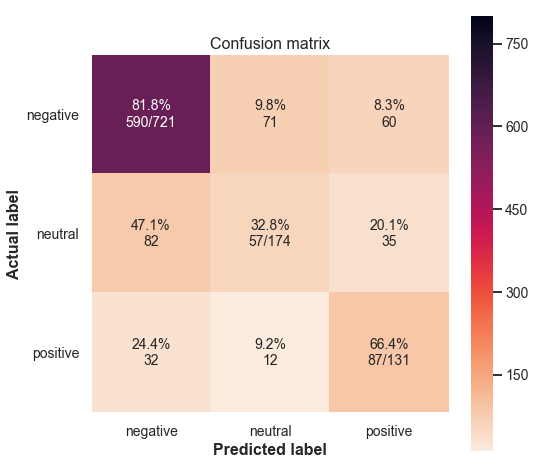

In [44]:
vectorizer = CountVectorizer(tokenizer=TokenizeTweet(), binary=False,
                             max_df=0.9, ngram_range=(1, 3), lowercase=False)

pipe = make_pipeline_imb(
    vectorizer,
    RandomUnderSampler(),
    MultinomialNB()
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred), '\n')
print(classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=y_pred))

plot_confusion_matrix(pipe.predict(X_test))

CountVectorizer, 90% threshold, binary

Accuracy:  0.7115009746588694 

              precision    recall  f1-score   support

    negative   0.819807  0.826630  0.823204       721
     neutral   0.448276  0.298851  0.358621       174
    positive   0.448087  0.625954  0.522293       131

   micro avg   0.711501  0.711501  0.711501      1026
   macro avg   0.572057  0.583811  0.568039      1026
weighted avg   0.709338  0.711501  0.705995      1026



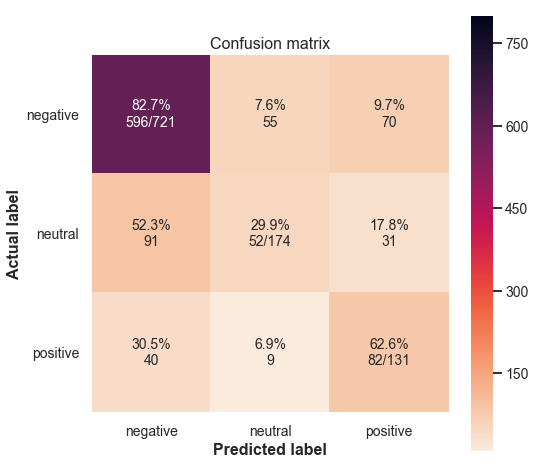

In [45]:
vectorizer = CountVectorizer(tokenizer=TokenizeTweet(), binary=True,
                             max_df=0.9, ngram_range=(1, 3), lowercase=False)

pipe = make_pipeline_imb(
    vectorizer,
    RandomUnderSampler(),
    MultinomialNB()
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred), '\n')
print(classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=y_pred))

plot_confusion_matrix(pipe.predict(X_test))

TfidfVectorizer, 90% threshold

Accuracy:  0.6500974658869396 

              precision    recall  f1-score   support

    negative   0.839733  0.697642  0.762121       721
     neutral   0.330579  0.459770  0.384615       174
    positive   0.454054  0.641221  0.531646       131

   micro avg   0.650097  0.650097  0.650097      1026
   macro avg   0.541455  0.599545  0.559461      1026
weighted avg   0.704141  0.650097  0.668673      1026



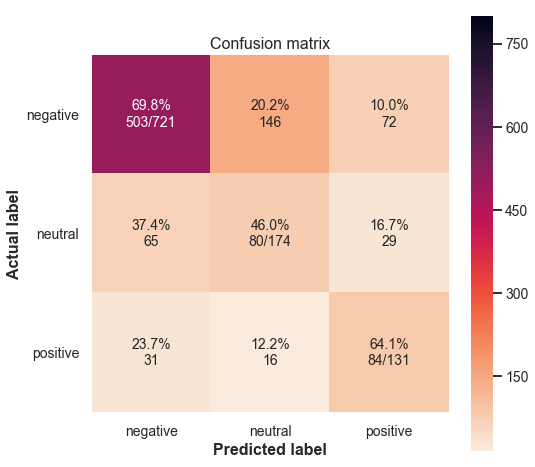

In [46]:
vectorizer = TfidfVectorizer(tokenizer=TokenizeTweet(), binary=False,
                             max_df=0.9, ngram_range=(1, 3), lowercase=False)

pipe = make_pipeline_imb(
    vectorizer,
    RandomUnderSampler(),
    MultinomialNB()
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred), '\n')
print(classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=y_pred))

plot_confusion_matrix(pipe.predict(X_test))

TfidfVectorizer, 90% threshold, binary

Accuracy:  0.6306042884990254 

              precision    recall  f1-score   support

    negative   0.843860  0.667129  0.745159       721
     neutral   0.301471  0.471264  0.367713       174
    positive   0.456522  0.641221  0.533333       131

   micro avg   0.630604  0.630604  0.630604      1026
   macro avg   0.533951  0.593205  0.548735      1026
weighted avg   0.702420  0.630604  0.654102      1026



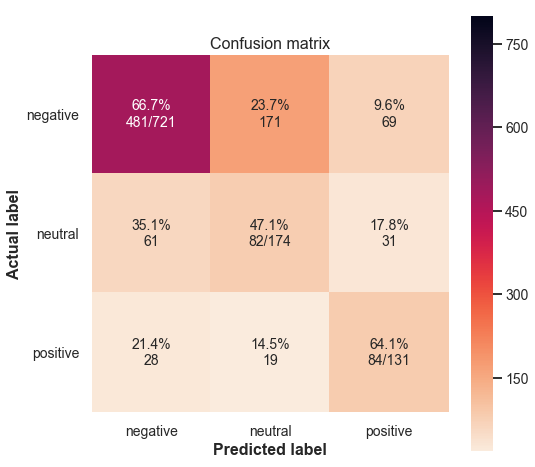

In [47]:
vectorizer = TfidfVectorizer(tokenizer=TokenizeTweet(), binary=True,
                             max_df=0.9, ngram_range=(1, 3), lowercase=False)

pipe = make_pipeline_imb(
    vectorizer,
    RandomUnderSampler(),
    MultinomialNB()
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred), '\n')
print(classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=y_pred))

plot_confusion_matrix(pipe.predict(X_test))

### <div style="background-color: #4D776B; color: #fcfcfc; padding: 1.2em;"><span style="float: right;">No preprocessing</span></div>

CountVectorizer, 90% threshold

Accuracy:  0.7592592592592593 

              precision    recall  f1-score   support

    negative   0.888060  0.825243  0.855500       721
     neutral   0.488636  0.494253  0.491429       174
    positive   0.544444  0.748092  0.630225       131

   micro avg   0.759259  0.759259  0.759259      1026
   macro avg   0.640380  0.689196  0.659051      1026
weighted avg   0.776448  0.759259  0.764993      1026



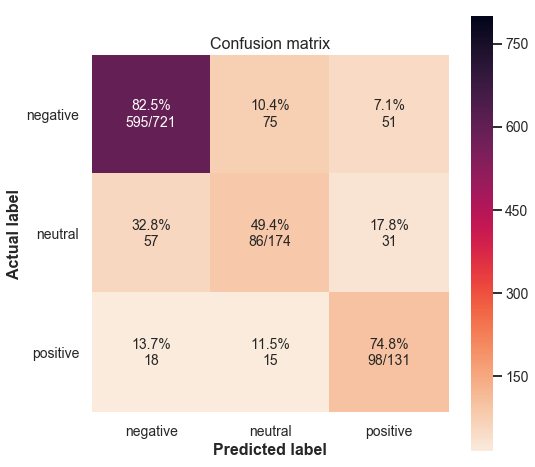

In [66]:
pipe = make_pipeline_imb(
    CountVectorizer(),
    RandomUnderSampler(),
    MultinomialNB()
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred), '\n')
print(classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=y_pred))

plot_confusion_matrix(pipe.predict(X_test))

CountVectorizer, 90% threshold, binary

Accuracy:  0.7582846003898636 

              precision    recall  f1-score   support

    negative   0.879412  0.829404  0.853676       721
     neutral   0.472527  0.494253  0.483146       174
    positive   0.573171  0.717557  0.637288       131

   micro avg   0.758285  0.758285  0.758285      1026
   macro avg   0.641703  0.680405  0.658037      1026
weighted avg   0.771307  0.758285  0.763209      1026



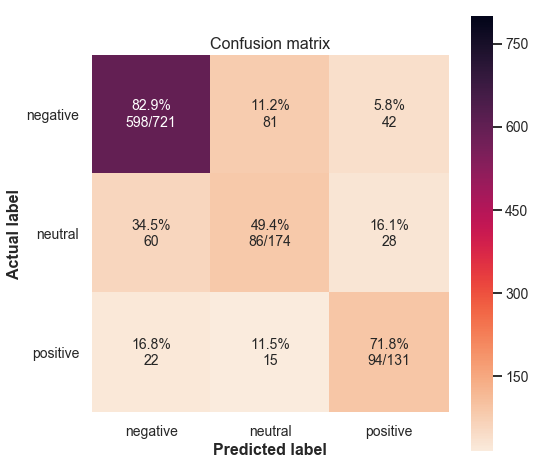

In [67]:
pipe = make_pipeline_imb(
    CountVectorizer(binary=True),
    RandomUnderSampler(),
    MultinomialNB()
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred), '\n')
print(classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=y_pred))

plot_confusion_matrix(pipe.predict(X_test))

TfidfVectorizer, 90% threshold

Accuracy:  0.7641325536062378 

              precision    recall  f1-score   support

    negative   0.893713  0.828017  0.859611       721
     neutral   0.517647  0.505747  0.511628       174
    positive   0.526596  0.755725  0.620690       131

   micro avg   0.764133  0.764133  0.764133      1026
   macro avg   0.645985  0.696496  0.663976      1026
weighted avg   0.783062  0.764133  0.770091      1026



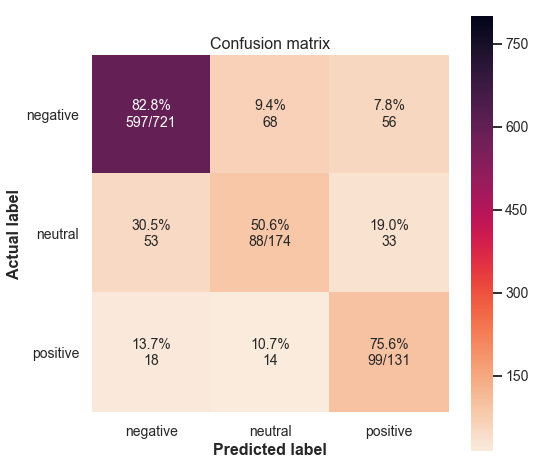

In [68]:
pipe = make_pipeline_imb(
    TfidfVectorizer(),
    RandomUnderSampler(),
    MultinomialNB()
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred), '\n')
print(classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=y_pred))

plot_confusion_matrix(pipe.predict(X_test))

TfidfVectorizer, 90% threshold, binary

Accuracy:  0.7543859649122807 

              precision    recall  f1-score   support

    negative   0.896764  0.807212  0.849635       721
     neutral   0.491803  0.517241  0.504202       174
    positive   0.525773  0.778626  0.627692       131

   micro avg   0.754386  0.754386  0.754386      1026
   macro avg   0.638114  0.701027  0.660510      1026
weighted avg   0.780718  0.754386  0.762715      1026



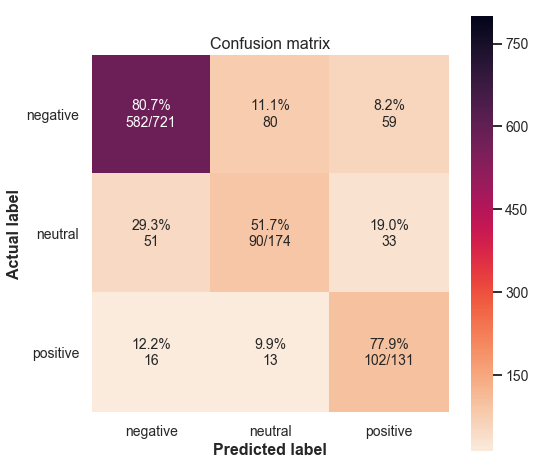

In [69]:
pipe = make_pipeline_imb(
    TfidfVectorizer(binary=True),
    RandomUnderSampler(),
    MultinomialNB()
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred), '\n')
print(classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=y_pred))

plot_confusion_matrix(pipe.predict(X_test))

### No resampling

### <div style="background-color: #4D776B; color: #fcfcfc; padding: 1.2em;"><span style="float: right;">With preprocessing</span></div>

CountVectorizer, 90% threshold, binary

Accuracy:  0.7222222222222222 

              precision    recall  f1-score   support

    negative   0.723964  0.993065  0.837427       721
     neutral   0.363636  0.022989  0.043243       174
    positive   0.807692  0.160305  0.267516       131

   micro avg   0.722222  0.722222  0.722222      1026
   macro avg   0.631764  0.392120  0.382729      1026
weighted avg   0.673546  0.722222  0.629974      1026



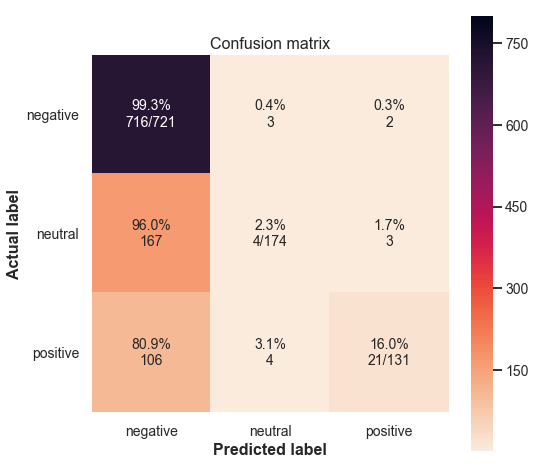

In [50]:
vectorizer = CountVectorizer(tokenizer=TokenizeTweet(), binary=True,
                             max_df=0.9, ngram_range=(1, 3), lowercase=False)

pipe = make_pipeline_imb(
    vectorizer,
#     NearMiss(),
    MultinomialNB()
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred), '\n')
print(classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=y_pred))

plot_confusion_matrix(pipe.predict(X_test))

In [51]:
show_most_informative_features(pipe.named_steps['countvectorizer'], pipe.named_steps['multinomialnb'])

	-10.5773	         513mph		-4.0191	              be
	-10.5773	  513mph strong		-4.5205	            have
	-10.5773	   able earlier		-4.5323	             not
	-10.5773	    able entire		-5.0166	             get
	-10.5773	able entire hold		-5.3355	              do
	-10.5773	       able get		-5.5084	             now
	-10.5773	able get reschedule		-5.5666	          cancel
	-10.5773	     able thank		-5.7021	          do not
	-10.5773	  absolute best		-5.7898	         have be
	-10.5773	absolute best check		-5.8588	            wait


CountVectorizer, 90% threshold


Accuracy:  0.7241715399610137 

              precision    recall  f1-score   support

    negative   0.725431  0.993065  0.838407       721
     neutral   0.363636  0.022989  0.043243       174
    positive   0.821429  0.175573  0.289308       131

   micro avg   0.724172  0.724172  0.724172      1026
   macro avg   0.636832  0.397209  0.390320      1026
weighted avg   0.676331  0.724172  0.633446      1026



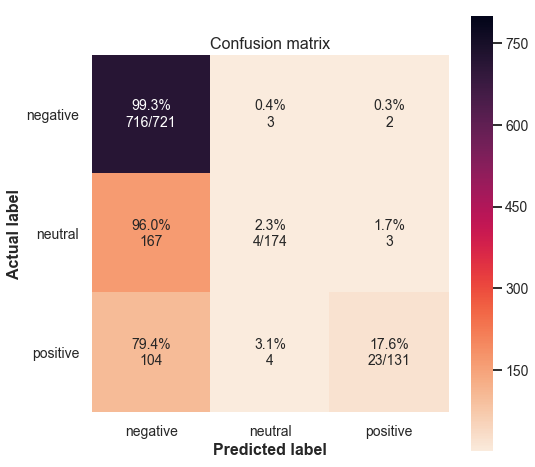

In [52]:
vectorizer = CountVectorizer(tokenizer=TokenizeTweet(), binary=False,
                             max_df=0.9, ngram_range=(1, 3), lowercase=False)

pipe = make_pipeline_imb(
    vectorizer,
#     NearMiss(),
    MultinomialNB()
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred), '\n')
print(classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=y_pred))

plot_confusion_matrix(pipe.predict(X_test))

In [53]:
show_most_informative_features(pipe.named_steps['countvectorizer'], pipe.named_steps['multinomialnb'])

	-10.5905	         513mph		-3.7926	              be
	-10.5905	  513mph strong		-4.4043	            have
	-10.5905	   able earlier		-4.4251	             not
	-10.5905	    able entire		-4.9486	             get
	-10.5905	able entire hold		-5.2530	              do
	-10.5905	       able get		-5.5029	             now
	-10.5905	able get reschedule		-5.5407	          cancel
	-10.5905	     able thank		-5.6705	          do not
	-10.5905	  absolute best		-5.7865	         have be
	-10.5905	absolute best check		-5.7947	            wait


TfidfVectorizer, 90% threshold, binary

Accuracy:  0.7066276803118908 

              precision    recall  f1-score   support

    negative   0.706863  1.000000  0.828260       721
     neutral   0.000000  0.000000  0.000000       174
    positive   1.000000  0.030534  0.059259       131

   micro avg   0.706628  0.706628  0.706628      1026
   macro avg   0.568954  0.343511  0.295840      1026
weighted avg   0.624413  0.706628  0.589608      1026



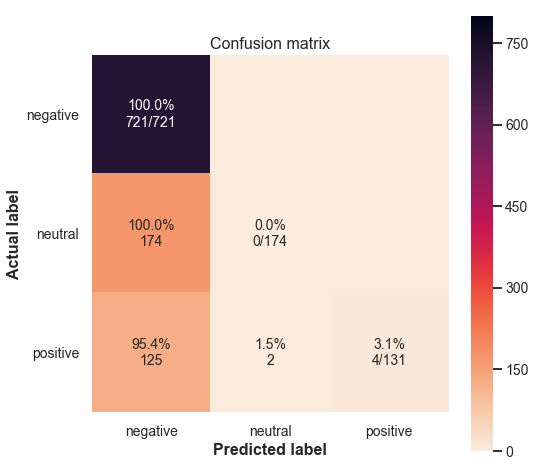

In [54]:
vectorizer = TfidfVectorizer(tokenizer=TokenizeTweet(), binary=True,
                             max_df=0.9, ngram_range=(1, 3), lowercase=False)

pipe = make_pipeline_imb(
    vectorizer,
#     NearMiss(),
    MultinomialNB()
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred), '\n')
print(classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=y_pred))

plot_confusion_matrix(pipe.predict(X_test))

In [55]:
show_most_informative_features(pipe.named_steps['tfidfvectorizer'], pipe.named_steps['multinomialnb'])

	-9.9699	         513mph		-5.8195	              be
	-9.9699	  513mph strong		-6.1396	            have
	-9.9699	   able earlier		-6.1773	             not
	-9.9699	    able entire		-6.4039	             get
	-9.9699	able entire hold		-6.7165	              do
	-9.9699	       able get		-6.7528	             now
	-9.9699	able get reschedule		-6.8001	          cancel
	-9.9699	     able thank		-6.8487	            wait
	-9.9699	  absolute best		-6.9220	         have be
	-9.9699	absolute best check		-6.9840	           still


TfidfVectorizer, 90% threshold

Accuracy:  0.7066276803118908 

              precision    recall  f1-score   support

    negative   0.706863  1.000000  0.828260       721
     neutral   0.000000  0.000000  0.000000       174
    positive   1.000000  0.030534  0.059259       131

   micro avg   0.706628  0.706628  0.706628      1026
   macro avg   0.568954  0.343511  0.295840      1026
weighted avg   0.624413  0.706628  0.589608      1026



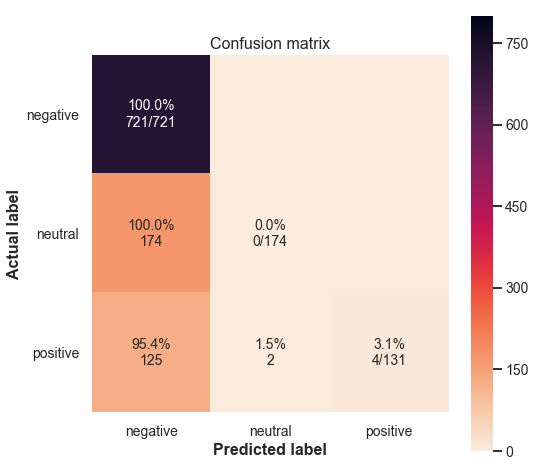

In [56]:
vectorizer = TfidfVectorizer(tokenizer=TokenizeTweet(), binary=False,
                             max_df=0.9, ngram_range=(1, 3), lowercase=False)

pipe = make_pipeline_imb(
    vectorizer,
#     NearMiss(),
    MultinomialNB()
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred), '\n')
print(classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=y_pred))

plot_confusion_matrix(pipe.predict(X_test))

### <div style="background-color: #4D776B; color: #fcfcfc; padding: 1.2em;"><span style="float: right;">No preprocessing</span></div>

CountVectorizer, 90% threshold, binary

Accuracy:  0.7660818713450293 

              precision    recall  f1-score   support

    negative   0.769231  0.984743  0.863747       721
     neutral   0.680000  0.195402  0.303571       174
    positive   0.792453  0.320611  0.456522       131

   micro avg   0.766082  0.766082  0.766082      1026
   macro avg   0.747228  0.500252  0.541280      1026
weighted avg   0.757063  0.766082  0.716752      1026



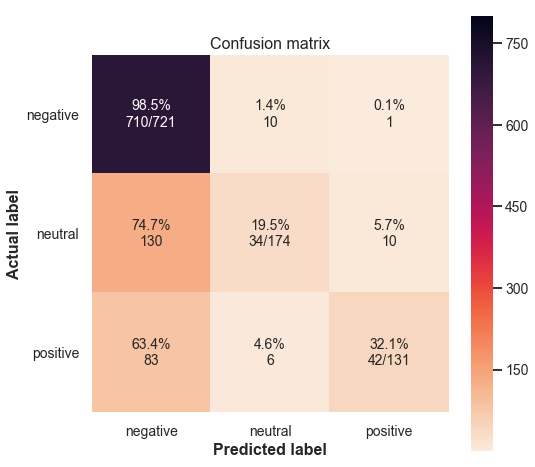

In [65]:
pipe = make_pipeline_imb(
    CountVectorizer(binary=True),
    MultinomialNB()
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred), '\n')
print(classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=y_pred))

plot_confusion_matrix(pipe.predict(X_test))

In [58]:
show_most_informative_features(pipe.named_steps['countvectorizer'], pipe.named_steps['multinomialnb'])

	-10.5256	           0185		-3.1158	       usairways
	-10.5256	           0736		-3.4660	              to
	-10.5256	           0769		-3.9002	             the
	-10.5256	            0_0		-4.1337	              on
	-10.5256	     0jjt4x3yxg		-4.1747	             and
	-10.5256	     0jutcdrljl		-4.1834	          flight
	-10.5256	       1000cost		-4.2066	             for
	-10.5256	           1230		-4.2892	             you
	-10.5256	            153		-4.4208	              my
	-10.5256	           1581		-4.4275	              is


CountVectorizer, 90% threshold


Accuracy:  0.7680311890838206 

              precision    recall  f1-score   support

    negative   0.770901  0.984743  0.864799       721
     neutral   0.679245  0.206897  0.317181       174
    positive   0.807692  0.320611  0.459016       131

   micro avg   0.768031  0.768031  0.768031      1026
   macro avg   0.752613  0.504084  0.546999      1026
weighted avg   0.760055  0.768031  0.720118      1026



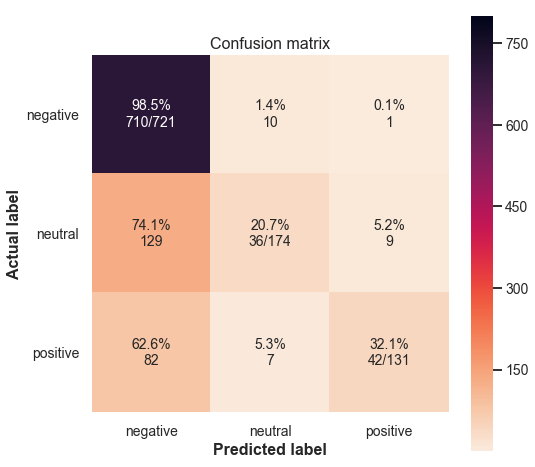

In [59]:
pipe = make_pipeline_imb(
    CountVectorizer(),
    MultinomialNB()
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred), '\n')
print(classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=y_pred))

plot_confusion_matrix(pipe.predict(X_test))

In [60]:
show_most_informative_features(pipe.named_steps['countvectorizer'], pipe.named_steps['multinomialnb'])

	-10.5256	           0185		-3.1158	       usairways
	-10.5256	           0736		-3.4660	              to
	-10.5256	           0769		-3.9002	             the
	-10.5256	            0_0		-4.1337	              on
	-10.5256	     0jjt4x3yxg		-4.1747	             and
	-10.5256	     0jutcdrljl		-4.1834	          flight
	-10.5256	       1000cost		-4.2066	             for
	-10.5256	           1230		-4.2892	             you
	-10.5256	            153		-4.4208	              my
	-10.5256	           1581		-4.4275	              is


TfidfVectorizer, 90% threshold, binary

Accuracy:  0.702729044834308 

              precision    recall  f1-score   support

    negative   0.704501  0.998613  0.826162       721
     neutral   0.250000  0.005747  0.011236       174
    positive   0.000000  0.000000  0.000000       131

   micro avg   0.702729  0.702729  0.702729      1026
   macro avg   0.318167  0.334787  0.279133      1026
weighted avg   0.537471  0.702729  0.582473      1026



/home/kayeval/Documents/ml_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


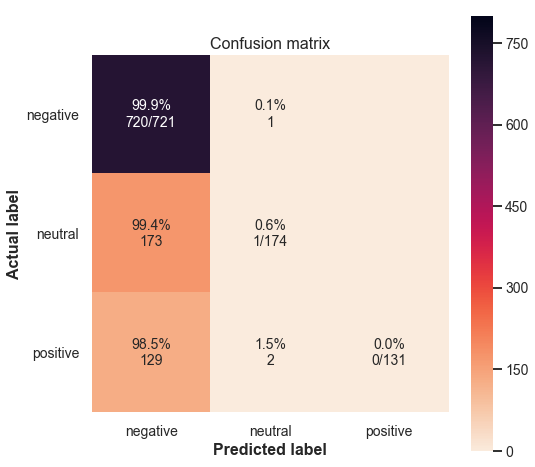

In [64]:
pipe = make_pipeline_imb(
    TfidfVectorizer(binary=True),
    MultinomialNB()
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred), '\n')
print(classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=y_pred))

plot_confusion_matrix(pipe.predict(X_test))

In [62]:
show_most_informative_features(pipe.named_steps['tfidfvectorizer'], pipe.named_steps['multinomialnb'])

	-9.3492	           0185		-4.7933	       usairways
	-9.3492	           0736		-4.7982	              to
	-9.3492	           0769		-5.0378	             the
	-9.3492	            0_0		-5.1461	              on
	-9.3492	     0jjt4x3yxg		-5.1919	          flight
	-9.3492	     0jutcdrljl		-5.1980	             and
	-9.3492	       1000cost		-5.2329	             for
	-9.3492	           1230		-5.2758	             you
	-9.3492	            153		-5.3260	              is
	-9.3492	           1581		-5.3293	              my


TfidfVectorizer, 90% threshold

Accuracy:  0.7046783625730995 

              precision    recall  f1-score   support

    negative   0.706575  0.998613  0.827586       721
     neutral   0.428571  0.017241  0.033149       174
    positive   0.000000  0.000000  0.000000       131

   micro avg   0.704678  0.704678  0.704678      1026
   macro avg   0.378382  0.338618  0.286912      1026
weighted avg   0.569213  0.704678  0.587191      1026



/home/kayeval/Documents/ml_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


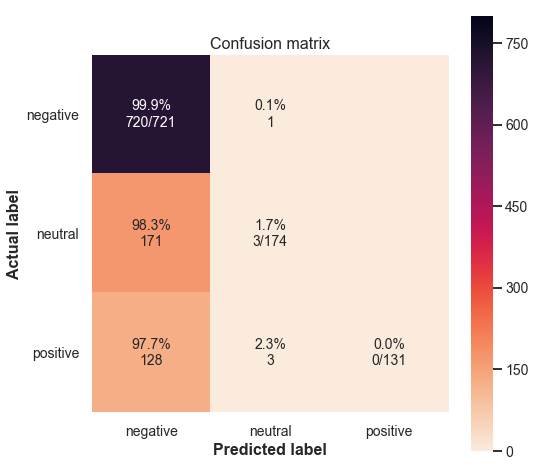

In [63]:
pipe = make_pipeline_imb(
    TfidfVectorizer(),
    MultinomialNB()
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred), '\n')
print(classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=y_pred))

plot_confusion_matrix(pipe.predict(X_test))


********
# Program Writeup

...


********
## remove this afterwards!

### Data

You may follow the procedure done in the Python notebook if you're not sure what to do.

Study the data and understand what you have before moving to techniques.

The dataset to be used is a smaller version and only contains the sentiment (positive, neutral, negative), the airline in question (Virgin America and US Airways), and the text from the tweet.

There are 3,462 tweets in total. Its up to you how you understand the corpus and how its structure might affect the eventual learning model.


### Pre-process + Feature Extraction

Use at least 3 different feature extraction techniques out of, but not limited to, the following:
1. Term counts
2. Term frequency
3. Term frequency inverse document frequency
4. POS tags
5. Word sense counts
6. Word sense frequency
7. Sentiment-related features

You're expected to test out different parameters (e.g. # of POS tags, min/max document frequency) for each. It would be nice to report these, but you may stick with the best parameters based on experiments.
You may or may not perform pre-processing / cleaning, but you must talk about the effects of processing the data or leaving it raw.
1. Can preprocessing help in the boasting the accuracy?
2. Is the way you're tokenizing affecting the output?
3. Look at things before the learning bit and craft features that might contain loads of information for the classifier.


### Machine Learning

Limit yourselves to Naive Bayes. You are free to use other ML algorithms, but kindly just use one and focus on the effect of the techniques.
Kindly measure accuracy and F1 score (F-measure) for each model for comparison.
For simplicity, you can just do a single train and test split (like how the Python notebook shows).

There is a lot of room for you to do your thing here, but again, you are to focus on experimenting with different data pre-processing techniques and feature extraction methods. Don't overdo it and just focus on complying with the specs of the assignment. If you want to experiment with more, feel free to do so. :)

Please also use tools, like those from ScikitLearn or NLTK. Don't stress yourselves out doing too much. Search for implementations of the techniques.

You are also to create a write-up. Write all your observations, queries, comments, violent reactions, whatever. Which features did best/worst? Does it make sense that the best/worst features performed in such a manner? Was the dataset even good in the first place? The write-up has heavier weight than the program, so despite the program, focus on experimentation and note everything down.